In [1]:
import sys
sys.path.append('../')

# Using `access` to Generate Gravity Scores with X, Y Coordinate Location Data


## Setup

In [2]:
import requests
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
from access import access, datasets, weights
%matplotlib inline

pd.options.display.max_rows = 1000
import warnings
warnings.filterwarnings('ignore')

## Data Prep
To calculate gravity scores for Cook County, you'll need:
- Shapefile for Cook County Census Tracts (2010)
- Cook County Census Tract population Data
- Cook County hospital locations with X, Y Coordinates
- Cost matrix for travel times between Cook County Census Tracts

For each of the above requirements, we will need to filter down larger datasets to obtain the Cook County subsets. 
- For the shapefile, we will use the [Illinois Catrographic Boundary File (2010)](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2010.html)
- For Cook County Census Tract population data, we will use a dataset containing population counts for every Illinois Census Tract.
- For the cost matrix with travel times between each Cook County Census Tract, we will use the [National Travel Time Cost Matrix](https://access.readthedocs.io/en/latest/resources.html).

Below, we show how the process for filtering each of these datasets for your convenience.

### Filtering Illinois Shapefile
Download the Illinois shapefile to the current directory.

In [3]:
il_shp_url = 'https://www2.census.gov/geo/tiger/GENZ2010/gz_2010_17_140_00_500k.zip'
req = requests.get(il_shp_url)
file_path = './gz_2010_17_140_00_500k.zip'

with open(file_path, 'wb') as f:
    f.write(req.content)

Unzip the file.

In [4]:
!unzip -o ./gz_2010_17_140_00_500k.zip 

Archive:  ./gz_2010_17_140_00_500k.zip
  inflating: gz_2010_17_140_00_500k.dbf  
  inflating: gz_2010_17_140_00_500k.prj  
  inflating: gz_2010_17_140_00_500k.shp  
  inflating: gz_2010_17_140_00_500k.shx  
  inflating: gz_2010_17_140_00_500k.xml  


Import the shapefile using [`geopandas.read_file`](http://geopandas.org/reference/geopandas.read_file.html). Once the file has been read in, we can plot the data to see Illinois.

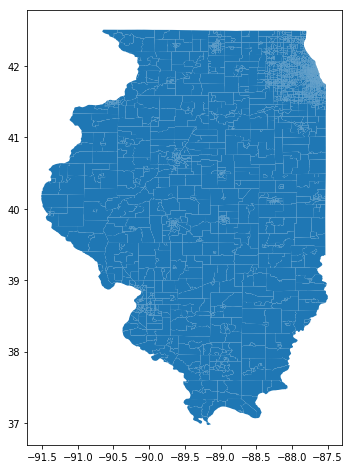

In [5]:
il_shp = gpd.read_file('./gz_2010_17_140_00_500k/gz_2010_17_140_00_500k.shp')
il_shp.plot(figsize=(8, 8))

You'll notice that Illinois looks a little distorted. That's because we need to assign to it a different [CRS (Coordinate Reference System)](https://en.wikipedia.org/wiki/Spatial_reference_system). Once we've assigned it an appropriate CRS, it will not appear distorted.

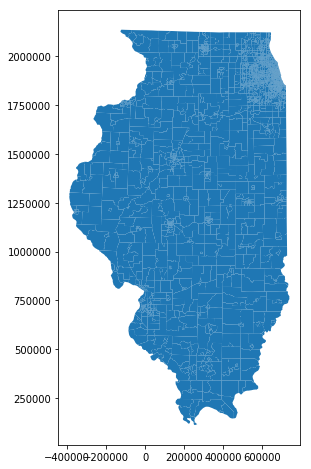

In [6]:
il_shp = il_shp.to_crs(epsg=26771)
il_shp.plot(figsize=(8,8))

In addition to being able to plot the shapefile data, it is also representable in table form as shown below.

In [7]:
il_shp.head()

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry
0,1400000US17031440300,17,031,440300,4403,Tract,0.499,"POLYGON ((696166.549 1849346.103, 696185.767 1..."
1,1400000US17031440600,17,031,440600,4406,Tract,0.259,"POLYGON ((696223.367 1847349.220, 696233.487 1..."
2,1400000US17031440700,17,031,440700,4407,Tract,0.126,"POLYGON ((697548.219 1847388.383, 698209.156 1..."
3,1400000US17031460200,17,031,460200,4602,Tract,0.232,"POLYGON ((713054.690 1850461.124, 713399.574 1..."
4,1400000US17031460600,17,031,460600,4606,Tract,0.101,"POLYGON ((712116.286 1847785.076, 712308.126 1..."


In order to get the subset of tracts for Cook County, we'll need to filter the dataset for the rows where **COUNTY** is **031**.

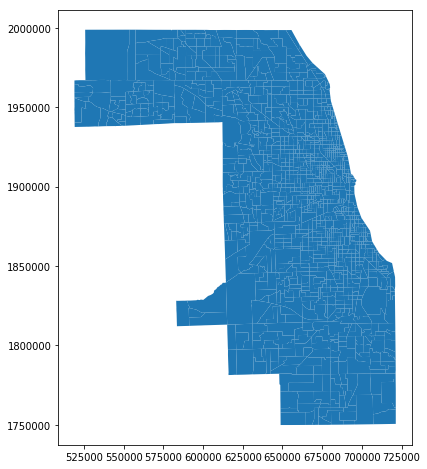

In [8]:
cook_county_tracts = il_shp[il_shp['COUNTY'] == '031']
cook_county_tracts.plot(figsize = (8,8))

Lastly, we will create a `geoid` column, set it as `int` type, and asign it as the index. 

In [9]:
cook_county_tracts['geoid'] = cook_county_tracts['STATE'] +\
                              cook_county_tracts['COUNTY'] +\
                              cook_county_tracts['TRACT']
cook_county_tracts['geoid'] = cook_county_tracts.geoid.astype(int)
cook_county_tracts.set_index('geoid', inplace=True)
cook_county_tracts.head()

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry
geoid,,,,,,,,
17031440300,1400000US17031440300,17,031,440300,4403,Tract,0.499,"POLYGON ((696166.549 1849346.103, 696185.767 1..."
17031440600,1400000US17031440600,17,031,440600,4406,Tract,0.259,"POLYGON ((696223.367 1847349.220, 696233.487 1..."
17031440700,1400000US17031440700,17,031,440700,4407,Tract,0.126,"POLYGON ((697548.219 1847388.383, 698209.156 1..."
17031460200,1400000US17031460200,17,031,460200,4602,Tract,0.232,"POLYGON ((713054.690 1850461.124, 713399.574 1..."
17031460600,1400000US17031460600,17,031,460600,4606,Tract,0.101,"POLYGON ((712116.286 1847785.076, 712308.126 1..."


Great, now we've got the geographic data we need. We will now proceed to filtering the population data.

### Filtering Illinois Population Data
In this case, we had already gathered Illinois' population data for each Census Tract. To obtain population data, you can use [American Fact Finder](https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml), among other methods.

In [10]:
il_pop = pd.read_csv('./il_pop.csv')
il_pop.head()

,geoid,pop
0,17001000100,4627
1,17001000201,1986
2,17001000202,2999
3,17001000400,4322
4,17001000500,2337


In the dataset above, you'll notice that `geoid` is a concatenation of the state, county, and tract identifiers. We will need to filter that column in order to obtain only Cook County tracts. However, we are presented with a challenge. The `geoid` is currently of type `int64`. We'll need to convert it to a `str` in order to filter the dataset and then return it to type `int64`.

In [11]:
il_pop.dtypes

geoid    int64
pop      int64
dtype: object

In [12]:
il_pop['geoid'] = il_pop.geoid.astype(str)
cook_pop = il_pop[il_pop['geoid'].str.startswith('17031')]
cook_pop['geoid'] = cook_pop.geoid.astype(int)
cook_pop.head()

,geoid,pop
139,17031010100,4854
140,17031010201,6450
141,17031010202,2818
142,17031010300,6236
143,17031010400,5042


In [13]:
cook_county_tracts.shape

(1318, 8)

In [14]:
cook_pop.shape

(1318, 2)

Great, now we have our subset of Cook County Census Tract population data. We can see just above that in both the shapefile and the population data, we have 1,318 rows of data, one for each Census Tract.

### Filtering Travel Time Cost Matrix
There will be several ways to filter the very large travel time cost matrix, and below we show two: 
1. Using [`dask`](https://dask.org/) 
2. Using the command line

First, we'll download and extract the National Travel Time Cost Matrix.

In [ ]:
dl_path = 'https://uchicago.box.com/shared/static/prapz7ac7vwuz44nnab3dhe10vbg55cz.bz2'
req = requests.get(dl_path)
file_path = './national-output-TRACT-CAR.csv.bz2'

with open(file_path, 'wb') as f:
    f.write(req.content)

In [ ]:
!bzip2 -dk national-output-TRACT-CAR.csv.bz2

Using `dask` we will now load the data to a dask dataframe, convert the `origin` and `destination` columns to type `str` just as we did above for the Illinois population data, and use the newly converted string column to filter for **17031**.

In [ ]:
national_cost_matrix = dd.read_csv('./national-output-TRACT-CAR.csv')
national_cost_matrix = national_cost_matrix[national_cost_matrix['origin'] != 'origin']
national_cost_matrix['origin'] = national_cost_matrix.origin.astype(str)
national_cost_matrix['destination'] = national_cost_matrix.destination.astype(str)

cook_county_fips = '17031'
cook_cost_matrix = national_cost_matrix[national_cost_matrix['origin'].str.startswith(cook_county_fips) &
                                        national_cost_matrix['destination'].str.startswith(cook_county_fips)]

With our delayed transformations setup, now we can execute our data transformations and have `dask` complete those transformations in parallel.

In [ ]:
cook_cost_matrix = cook_cost_matrix.compute()

In [15]:
cook_cost_matrix = pd.read_csv('./cook_cost_matrix.csv')

In [16]:
cook_cost_matrix.head()

,origin,destination,minutes
0,17031010100,17031010100,0.17
1,17031010100,17031010201,5.70
2,17031010100,17031010202,2.63
3,17031010100,17031010300,3.58
4,17031010100,17031010400,8.53


In [17]:
cook_cost_matrix.shape

(1737124, 3)

Based on the shape of the resulting dataset, we can see that we have one row for each of the Census Tracts to every other Census Tract in Cook County. We can confirm this by showing that 1,318 squared equals 1,737,124.

In [18]:
1318**2

1737124

Before proceeding, we'll need to change the names of two of our columns.

In [19]:
cook_cost_matrix = cook_cost_matrix.rename(columns={'destination':'dest', 'minutes':'cost'})

### Loading Cook County Hospital Data with X, Y Coordinates
Now we will load the Cook County hospital data and show how to join the data with X, Y coordinates to our shapefile data, matching each hospital to a Census Tract. 

In [20]:
cook_county_hospitals = gpd.read_file('./hospitals_cookcty.geojson')
cook_county_hospitals.head()

,ADDRESS,CFNAME,CFSUBTYPE,CFTYPE,Community,GNISCODE,Jurisdicti,OBJECTID,SOURCE,COORD_X,COORD_Y,geometry
0,9340 S Kostner Ave,Advocate Christ Medical Center,Hospital,Hospital,Oak Lawn,426825.0,None,1,CGI,1.148290e+06,1.841934e+06,POINT (-87.73244 41.72220)
1,15300 West Ave,Palos Primary Care Center,Hospital,Hospital,Orland Park,2036658.0,None,2,CL,1.112171e+06,1.801018e+06,POINT (-87.86555 41.61053)
2,15901 Cicero Ave,Oak Forest Hospital,Hospital,Hospital,Bremen Twp,414760.0,None,3,CEGL,1.148862e+06,1.797286e+06,POINT (-87.73149 41.59967)
3,375 W North Ave,Gottlieb Memorial Hospital,Hospital,Hospital,Melrose Park,409212.0,None,4,BCEG,1.117588e+06,1.910459e+06,POINT (-87.84347 41.91078)
4,2100 Pfingsten Rd,Glenbrook Hospital,Hospital,Hospital,Glenview,2033578.0,None,5,CEGI,1.114997e+06,1.976713e+06,POINT (-87.85161 42.09263)


Above, we can see that the data contains a `geometry` value for each hospital. If we plot this data over our Census Tract data, we can see the locations of each of the hospitals. However, before we do so, we must update the CRS on the dataset just as we did with the boundary file.

In [21]:
cook_county_hospitals = cook_county_hospitals.to_crs(epsg=26771)

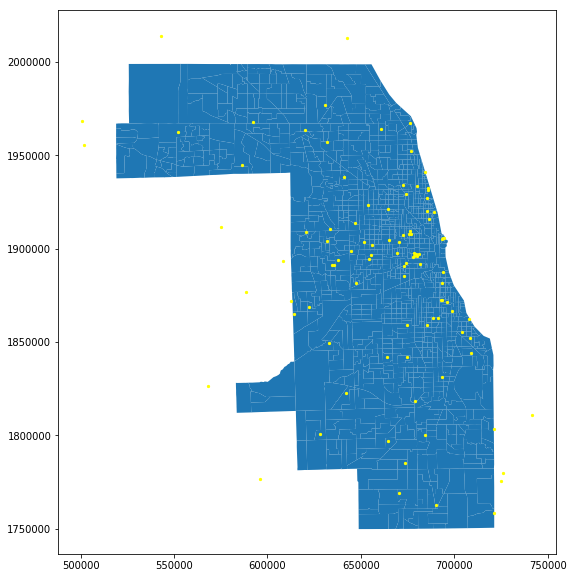

In [22]:
base = cook_county_tracts.plot(figsize=(10,10))
cook_county_hospitals.plot(ax=base, color='yellow', markersize=5)

To join these two datasets, we can use [`geopandas.sjoin`](http://geopandas.org/mergingdata.html#spatial-joins).

In [23]:
cook_county_hospitals_w_tracts = gpd.sjoin(cook_county_hospitals, cook_county_tracts, how='inner', op='intersects')
cook_county_hospitals_w_tracts = cook_county_hospitals_w_tracts.rename(columns={'index_right':'geoid'})
cook_county_hospitals_w_tracts.head()

,ADDRESS,CFNAME,CFSUBTYPE,CFTYPE,Community,GNISCODE,Jurisdicti,OBJECTID,SOURCE,COORD_X,COORD_Y,geometry,geoid,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA
0,9340 S Kostner Ave,Advocate Christ Medical Center,Hospital,Hospital,Oak Lawn,426825.0,None,1,CGI,1.148290e+06,1.841934e+06,POINT (664056.753 1841870.497),17031822102,1400000US17031822102,17,031,822102,8221.02,Tract,0.866
1,15300 West Ave,Palos Primary Care Center,Hospital,Hospital,Orland Park,2036658.0,None,2,CL,1.112171e+06,1.801018e+06,POINT (627938.607 1800954.929),17031824116,1400000US17031824116,17,031,824116,8241.16,Tract,3.100
2,15901 Cicero Ave,Oak Forest Hospital,Hospital,Hospital,Bremen Twp,414760.0,None,3,CEGL,1.148862e+06,1.797286e+06,POINT (664628.538 1797222.632),17031825200,1400000US17031825200,17,031,825200,8252,Tract,0.912
3,375 W North Ave,Gottlieb Memorial Hospital,Hospital,Hospital,Melrose Park,409212.0,None,4,BCEG,1.117588e+06,1.910459e+06,POINT (633355.451 1910394.617),17031811302,1400000US17031811302,17,031,811302,8113.02,Tract,1.544
4,2100 Pfingsten Rd,Glenbrook Hospital,Hospital,Hospital,Glenview,2033578.0,None,5,CEGI,1.114997e+06,1.976713e+06,POINT (630764.432 1976649.013),17031801607,1400000US17031801607,17,031,801607,8016.07,Tract,2.154


Lastly, we will need to create a "supply value" for each hospital in the dataset. This will be explained later.

In [24]:
cook_county_hospitals_w_tracts['supply'] = 1
cook_county_hospitals_w_tracts.head()

,ADDRESS,CFNAME,CFSUBTYPE,CFTYPE,Community,GNISCODE,Jurisdicti,OBJECTID,SOURCE,COORD_X,...,geometry,geoid,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,supply
0,9340 S Kostner Ave,Advocate Christ Medical Center,Hospital,Hospital,Oak Lawn,426825.0,None,1,CGI,1.148290e+06,...,POINT (664056.753 1841870.497),17031822102,1400000US17031822102,17,031,822102,8221.02,Tract,0.866,1
1,15300 West Ave,Palos Primary Care Center,Hospital,Hospital,Orland Park,2036658.0,None,2,CL,1.112171e+06,...,POINT (627938.607 1800954.929),17031824116,1400000US17031824116,17,031,824116,8241.16,Tract,3.100,1
2,15901 Cicero Ave,Oak Forest Hospital,Hospital,Hospital,Bremen Twp,414760.0,None,3,CEGL,1.148862e+06,...,POINT (664628.538 1797222.632),17031825200,1400000US17031825200,17,031,825200,8252,Tract,0.912,1
3,375 W North Ave,Gottlieb Memorial Hospital,Hospital,Hospital,Melrose Park,409212.0,None,4,BCEG,1.117588e+06,...,POINT (633355.451 1910394.617),17031811302,1400000US17031811302,17,031,811302,8113.02,Tract,1.544,1
4,2100 Pfingsten Rd,Glenbrook Hospital,Hospital,Hospital,Glenview,2033578.0,None,5,CEGI,1.114997e+06,...,POINT (630764.432 1976649.013),17031801607,1400000US17031801607,17,031,801607,8016.07,Tract,2.154,1


## Creating an `access` Object with Our Prepared Data
Now that we've prepared our data, we can create an instance of the `access` class and be well on our way to generating our gravity scores for the hospitals.

In [25]:
cook_hospitals_access = access(demand_df=cook_pop, demand_index='geoid', demand_value='pop',
                        supply_df=cook_county_hospitals_w_tracts, supply_index='geoid', supply_value='supply',
                        cost_df=cook_cost_matrix, cost_origin='origin', cost_dest='dest',
                        cost_name='cost')

In [26]:
gravity = weights.gravity(scale = 60, alpha = -1)

In [27]:
cook_hospitals_access.weighted_catchment(name = "gravity", weight_fn = gravity)

,gravity_supply
geoid,
17031010100,130.214432
17031010201,138.250839
17031010202,134.848609
17031010300,134.680466
17031010400,149.495198
17031010501,138.766679
17031010502,147.315691
17031010503,166.296074
17031010600,149.410162


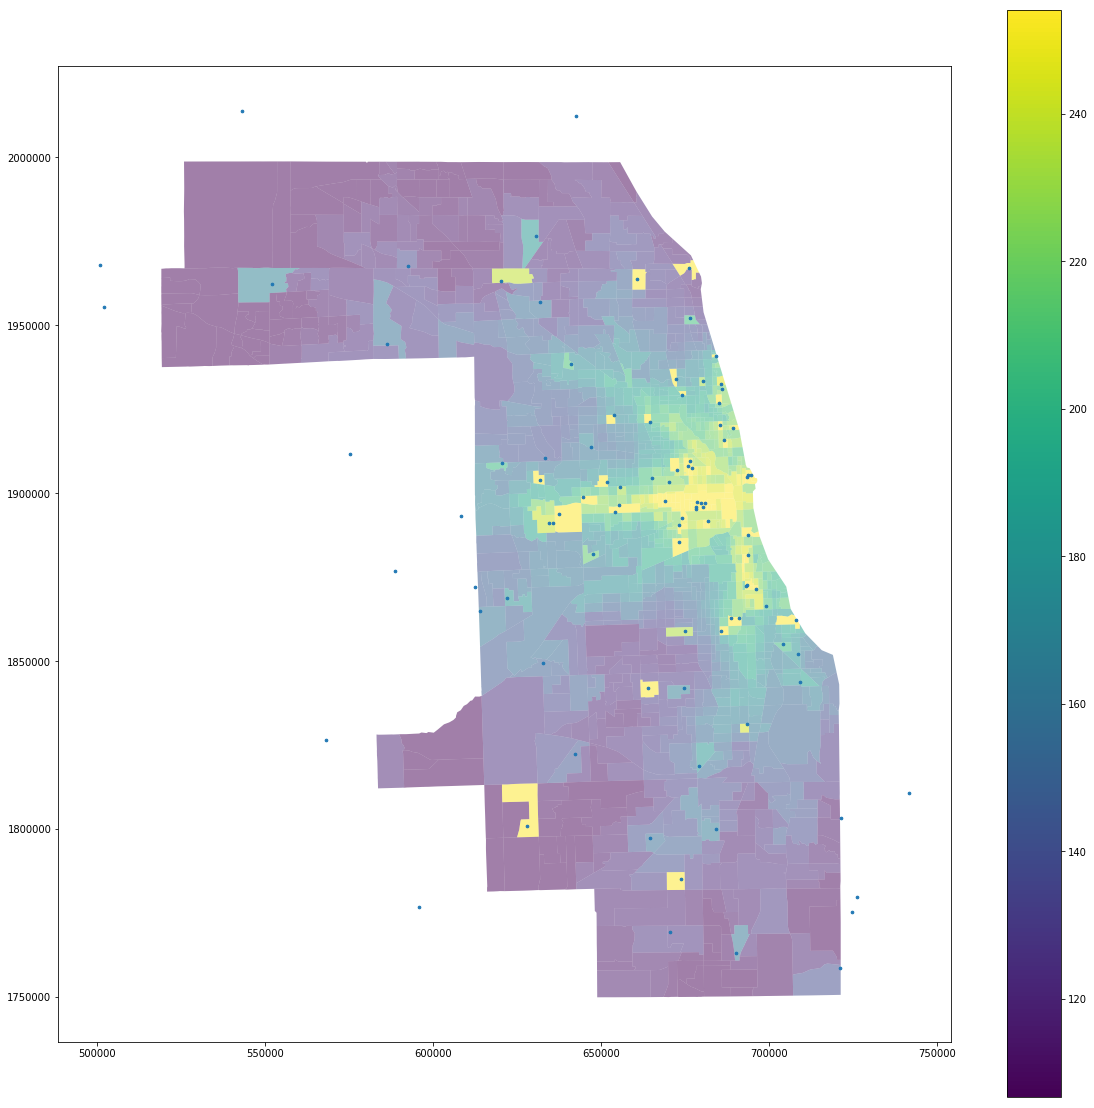

In [28]:
cook_map = cook_county_tracts[["geometry"]].join(cook_hospitals_access.access_df, how = "inner")
v = 'gravity_supply'
base = cook_map.plot(v, legend = True, figsize = (20, 20), cmap = "viridis", markersize = .5, alpha = 0.5,
            vmin = cook_map[v].quantile(0.05), vmax = cook_map[v].quantile(0.95))
cook_county_hospitals.plot(ax=base, markersize=7)